In [9]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np
import torch.nn.functional as F


# the model with mmoe and discrimanator

In [10]:

class MMoE(nn.Module):
    def __init__(self, input_dim, expert_dim, num_experts, num_tasks, output_dim, num_fc_layers=2):
        """
        Initialize the MMoE model.

        Args:
            input_dim (int): Input dimension for the features.
            expert_dim (int): Dimensionality of the output from each expert.
            num_experts (int): Number of experts in the MMoE model.
            num_tasks (int): Number of tasks to be solved (e.g., classification tasks).
            output_dim (int): Output dimension for each task.
            num_fc_layers (int): Number of fully connected layers in the experts and gates.
        """
        super(MMoE, self).__init__()
        
        self.num_tasks = num_tasks
        self.num_experts = num_experts
        
        # Experts: A shared set of experts (fully connected layers)
        self.experts = nn.ModuleList([self._build_fc_layers(input_dim, expert_dim, num_fc_layers) for _ in range(num_experts)])
        
        # Gates: One gating network per task
        self.gates = nn.ModuleList([self._build_fc_layers(input_dim, num_experts, num_fc_layers) for _ in range(num_tasks)])
        
        # Output layers: One output layer per task
        self.output_layers = nn.ModuleList([nn.Linear(expert_dim, output_dim) for _ in range(num_tasks)])

    def _build_fc_layers(self, input_dim, output_dim, num_fc_layers):
        """Build a sequence of fully connected layers."""
        layers = []
        for i in range(num_fc_layers):
            in_dim = input_dim if i == 0 else output_dim
            layers.append(nn.Linear(in_dim, output_dim))
            if i < num_fc_layers - 1:  # No activation on the final layer
                layers.append(nn.ReLU())
        return nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass through the MMoE model.

        Args:
            x (Tensor): Input tensor (batch_size, input_dim).
        
        Returns:
            outputs (list of Tensors): A list of task-specific outputs.
        """
        # Get expert outputs
        expert_outputs = [expert(x) for expert in self.experts]
        #print("exper",expert_outputs.shape)
        
        # Stack expert outputs to shape (batch_size, num_experts, expert_dim)
        expert_outputs = torch.stack(expert_outputs, dim=1)
        
        # Get the output for each task
        outputs = []
        for i in range(self.num_tasks):
            gate_output = self.gates[i](x)  # (batch_size, num_experts)
            gate_output = F.softmax(gate_output, dim=1)  # Normalize to get the weights
            
            # Weighted sum of expert outputs for the task
            task_output = torch.sum(gate_output.unsqueeze(2) * expert_outputs, dim=1)  # (batch_size, expert_dim)
            
            # Apply task-specific output layer
            task_output = self.output_layers[i](task_output)
            outputs.append(task_output)
        
        return outputs




# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # (64, 32, 32)
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Flatten(),  # (512 * 4 * 4 = 8192)
            nn.Linear(512 * 4 * 4, 1),  # Fully connected layer to a single output
            nn.Sigmoid()  # Output: probability for binary classification
        )

    def forward(self, x):
        return self.model(x)

class TextImageSimilarityModel(nn.Module):
    def __init__(self, text_image_input_dim, input_dim, embed_dim, num_fc_layers, expert_dim, num_experts, num_tasks, output_dim, num_fc_layers_mmoe):
        super(TextImageSimilarityModel, self).__init__()
        
        # Text branch
        self.text_layers = self._build_fc_layers(input_dim, embed_dim, num_fc_layers)
        
        # Image branch
        self.image_layers = self._build_fc_layers(input_dim, embed_dim, num_fc_layers)
        
        self.mmoe = MMoE(text_image_input_dim, expert_dim, num_experts, num_tasks, output_dim, num_fc_layers_mmoe)
        
        self.discriminator = Discriminator()
        
        # Final fully connected layer for output
        self.fc_layer = nn.Linear(1 + output_dim, 1)  # Adjust based on the concatenated dimensions
        
    def _build_fc_layers(self, input_dim, embed_dim, num_fc_layers):
        layers = []
        for i in range(num_fc_layers):
            in_dim = input_dim if i == 0 else embed_dim
            out_dim = embed_dim
            layers.append(nn.Linear(in_dim, out_dim))
            if i < num_fc_layers - 1:
                layers.append(nn.ReLU())
        return nn.Sequential(*layers)
    
    def forward(self, text_features, image_features, image):
        # Process text features
        text_embedding = self.text_layers(text_features)
        text_embedding = F.normalize(text_embedding, dim=-1)
        
        # Process image features
        image_embedding = self.image_layers(image_features)
        image_embedding = F.normalize(image_embedding, dim=-1)
        
        # Concatenate the text and image embeddings
        combined_features = torch.cat([text_embedding, image_embedding], dim=-1)
        
        # Pass the combined features to MMoE
        task_outputs = self.mmoe(combined_features)
        
        # For discriminator
        out_dis = self.discriminator(image)
        
        # Concatenate task_outputs[0] and discriminator output
        
        combined_out = torch.cat([task_outputs[0], out_dis], dim=-1)
        
        # Pass through the final FC layer
        out = self.fc_layer(combined_out)
        
        return out



#Example usage
model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=4)#.to('cuda')

# Dummy data
text_features = torch.randn(32, 512)  # Example text features batch (batch size, input_dim)
image_features = torch.randn(32, 512)  # Example image features batch (batch size, input_dim)
image = torch.randn(32, 3, 64, 64)  # Example image batch (batch size, channels, height, width)

# Forward pass
outputs = model(text_features, image_features, image)
print(outputs.shape)


torch.Size([32, 1])


# training function

In [20]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def train_model_with_plot(
    model,
    text_features,
    image_features,
    image,
    labels,
    num_epochs=10,
    learning_rate=1e-4,
    margin=0.5,
    batch_size=32,
    val_split=0.2,
    device='cuda' if torch.cuda.is_available() else 'cpu'
):
    # Split data into training and validation sets
    num_samples = text_features.size(0)
    val_size = int(num_samples * val_split)
    train_size = num_samples - val_size

    # Create random indices for splitting
    indices = torch.randperm(num_samples)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    # Split the data
    train_text_features = text_features[train_indices]
    train_image_features = image_features[train_indices]
    train_image = image[train_indices]
    train_labels = labels[train_indices]

    val_text_features = text_features[val_indices]
    val_image_features = image_features[val_indices]
    val_image = image[val_indices]
    val_labels = labels[val_indices]

    # Move data to the device
    train_text_features = train_text_features.to(device)
    print(f'train_text_features device: {train_text_features.device}')
    train_image_features = train_image_features.to(device)
    print(f'train_image_features device: {train_image_features.device}')
    train_image = train_image.to(device)
    print(f'train_image device: {train_image.device}')
    train_labels = train_labels.to(device)
    print(f'train_labels device: {train_labels.device}')

    val_text_features = val_text_features.to(device)
    print(f'val_text_features device: {val_text_features.device}')
    val_image_features = val_image_features.to(device)
    print(f'val_image_features device: {val_image_features.device}')
    val_image = val_image.to(device)
    print(f'val_image device: {val_image.device}')
    val_labels = val_labels.to(device)
    print(f'val_labels device: {val_labels.device}')

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    # Lists to store loss and accuracy for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()

        epoch_loss = 0.0
        correct_train_preds = 0
        total_train_samples = 0

        # Shuffle the training data
        train_indices = torch.randperm(train_text_features.size(0))
        train_text_features = train_text_features[train_indices]
        train_image_features = train_image_features[train_indices]
        train_image = train_image[train_indices]
        train_labels = train_labels[train_indices]

        # Process data in batches
        num_batches = (train_text_features.size(0) + batch_size - 1) // batch_size
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, train_text_features.size(0))
            batch_text_features = train_text_features[start_idx:end_idx]
            batch_image_features = train_image_features[start_idx:end_idx]
            batch_image = train_image[start_idx:end_idx]
            batch_labels = train_labels[start_idx:end_idx]

            optimizer.zero_grad()
            # Forward pass
            outputs = model(batch_text_features, batch_image_features, batch_image)

            # Flatten labels for BCE loss
            labels_flat = batch_labels.view(-1)  # Flatten the batch of labels
            outputs_flat = torch.cat([out.view(-1) for out in outputs], dim=0)  # Flatten all task outputs

            # Compute the binary cross entropy loss
            loss = criterion(outputs_flat, labels_flat)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Calculate accuracy
            preds = torch.sigmoid(outputs_flat) > 0.5
            correct_train_preds += (preds == labels_flat).sum().item()
            total_train_samples += labels_flat.size(0)

        epoch_loss /= num_batches
        train_accuracies.append(correct_train_preds / total_train_samples)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0
        total_val_samples = 0
        with torch.no_grad():
            num_val_batches = (val_text_features.size(0) + batch_size - 1) // batch_size
            for val_batch_idx in range(num_val_batches):
                start_idx = val_batch_idx * batch_size
                end_idx = min((val_batch_idx + 1) * batch_size, val_text_features.size(0))
                val_batch_text_features = val_text_features[start_idx:end_idx]
                val_batch_image_features = val_image_features[start_idx:end_idx]
                val_batch_image = val_image[start_idx:end_idx]
                val_batch_labels = val_labels[start_idx:end_idx]

                val_out = model(val_batch_text_features, val_batch_image_features, val_batch_image)
                # Flatten labels for BCE loss
                val_labels_flat = val_batch_labels.view(-1)  # Flatten the batch of labels
                val_outputs_flat = torch.cat([out.view(-1) for out in val_out], dim=0)  # Flatten all task outputs

                # Compute the binary cross entropy loss
                batch_val_loss = criterion(val_outputs_flat, val_labels_flat)
                val_loss += batch_val_loss.item()

                # Calculate accuracy
                preds = torch.sigmoid(val_outputs_flat) > 0.5
                correct_val_preds += (preds == val_labels_flat).sum().item()
                total_val_samples += val_labels_flat.size(0)

        val_loss /= num_val_batches
        val_accuracies.append(correct_val_preds / total_val_samples)
        train_losses.append(epoch_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, " f"Train Loss: {epoch_loss:.4f}, " f"Train Acc: {train_accuracies[-1]:.4f}, " f"Val Loss: {val_loss:.4f}, " f"Val Acc: {val_accuracies[-1]:.4f}")

    # Plot training and validation losses and accuracies
    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

    return model

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plot training and validation losses over epochs.

    Args:
        train_losses (list): List of training losses over epochs.
        val_losses (list): List of validation losses over epochs.
        train_accuracies (list): List of training accuracies over epochs.
        val_accuracies (list): List of validation accuracies over epochs.
    """
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# test function

In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score,precision_recall_curve,average_precision_score
import matplotlib.pyplot as plt
import numpy as np

def test_model(model, test_text_features, test_image_features, test_images, test_labels, batch_size=32):
    """
    Evaluate the model on the test dataset and compute precision, recall, F1 score, and confusion matrix.
    Also, plot the Precision-Recall curve.
    
    Args:
        model (nn.Module): The trained model to evaluate.
        test_text_features (Tensor): Test text features of shape (N, text_feature_dim).
        test_image_features (Tensor): Test image features of shape (N, image_feature_dim).
        test_images (Tensor): Test images of shape (N, C, H, W).
        test_labels (Tensor): Ground truth labels of shape (N,).
        batch_size (int): Batch size for evaluation.

    Returns:
        metrics (dict): Dictionary containing precision, recall, F1 score, accuracy, and confusion matrix.
    """
    model.eval()  # Set model to evaluation mode
    num_samples = test_text_features.size(0)
    num_batches = (num_samples + batch_size - 1) // batch_size

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min(start_idx + batch_size, num_samples)

            text_batch = test_text_features[start_idx:end_idx]
            image_feature_batch = test_image_features[start_idx:end_idx]
            image_batch = test_images[start_idx:end_idx]
            batch_labels = test_labels[start_idx:end_idx]

            # Forward pass
            outputs = model(text_batch, image_feature_batch, image_batch)
            probabilities = outputs.squeeze().cpu().numpy()  # Convert to numpy
            predictions = (probabilities >= 0.5).astype(int)  # Binary classification

            # Store labels and predictions for metric calculations
            all_labels.extend(batch_labels.cpu().numpy())
            all_predictions.extend(predictions)

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Compute confusion matrix, precision, recall, F1 score, and accuracy
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    accuracy = accuracy_score(all_labels, all_predictions)

    # Print metrics
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")

    # Compute metrics for each class
    precision_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0]) if (conf_matrix[0, 0] + conf_matrix[1, 0]) > 0 else 0
    recall_0 = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1]) if (conf_matrix[0, 0] + conf_matrix[0, 1]) > 0 else 0
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0

    precision_1 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1]) if (conf_matrix[1, 1] + conf_matrix[0, 1]) > 0 else 0
    recall_1 = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0]) if (conf_matrix[1, 1] + conf_matrix[1, 0]) > 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

    print(f"Class 0: Precision={precision_0:.2f}, Recall={recall_0:.2f}, F1 Score={f1_0:.2f}")
    print(f"Class 1: Precision={precision_1:.2f}, Recall={recall_1:.2f}, F1 Score={f1_1:.2f}")
    
        # Calculate precision, recall, and thresholds
    precision, recall, thresholds = precision_recall_curve(all_labels, all_predictions)

    # Calculate Average Precision (AP) score
    average_precision = average_precision_score(all_labels, all_predictions)

    # Plot the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {average_precision:.2f}', color='b')

    # Add plot details
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix)

    return {
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "confusion_matrix": conf_matrix
    }

def plot_confusion_matrix(conf_matrix):
    """
    Plots the confusion matrix using matplotlib.
    
    Args:
        conf_matrix (np.ndarray): Confusion matrix to plot.
    
    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(5, 4))
    cax = ax.matshow(conf_matrix, cmap="Blues")

    # Add color bar
    fig.colorbar(cax)

    # Add labels and titles
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')

    # Annotate each cell with the numeric value
    for (i, j), value in np.ndenumerate(conf_matrix):
        ax.text(j, i, f'{value}', ha='center', va='center', color='black')

    # Set x and y ticks
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Fake', 'Real'])
    ax.set_yticklabels(['Fake', 'Real'])

    plt.show()


In [4]:
# Function to calculate total parameters in a model
def count_parameters(model):
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable_params, non_trainable_params

In [6]:
# Device configuration
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda'


model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=4).to(device)

# Calculate trainable and non-trainable parameters
trainable_params, non_trainable_params = count_parameters(model)
print(f"Trainable parameters: {trainable_params}")
print(f"Non-trainable parameters: {non_trainable_params}")

Trainable parameters: 3795206
Non-trainable parameters: 0


# The best model

C:\Users\swaru\AppData\Local\Temp\ipykernel_192832\44560825.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_features = torch.load('clip_train_text_features.pt').to(

Train text features shape: torch.Size([14254, 512])
Train image features shape: torch.Size([14254, 512])


C:\Users\swaru\AppData\Local\Temp\ipykernel_192832\44560825.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_features = torch.load('clip_train_image_features.pt').t

train_text_features device: cuda:0
train_image_features device: cuda:0
train_image device: cuda:0
train_labels device: cuda:0
val_text_features device: cuda:0
val_image_features device: cuda:0
val_image device: cuda:0
val_labels device: cuda:0
Epoch 1/10, Train Loss: 0.5800, Train Acc: 0.9482, Val Loss: 0.5812, Val Acc: 0.9835
Epoch 2/10, Train Loss: 0.5575, Train Acc: 0.9947, Val Loss: 0.5503, Val Acc: 0.9912
Epoch 3/10, Train Loss: 0.5242, Train Acc: 0.9971, Val Loss: 0.4783, Val Acc: 0.9947
Epoch 4/10, Train Loss: 0.4015, Train Acc: 0.9940, Val Loss: 0.3074, Val Acc: 0.9958
Epoch 5/10, Train Loss: 0.2511, Train Acc: 0.9948, Val Loss: 0.1967, Val Acc: 0.9965
Epoch 6/10, Train Loss: 0.1696, Train Acc: 0.9947, Val Loss: 0.1224, Val Acc: 0.9961
Epoch 7/10, Train Loss: 0.0828, Train Acc: 0.9954, Val Loss: 0.0464, Val Acc: 0.9954
Epoch 8/10, Train Loss: 0.0288, Train Acc: 0.9961, Val Loss: 0.0245, Val Acc: 0.9954
Epoch 9/10, Train Loss: 0.0156, Train Acc: 0.9973, Val Loss: 0.0211, Val Acc

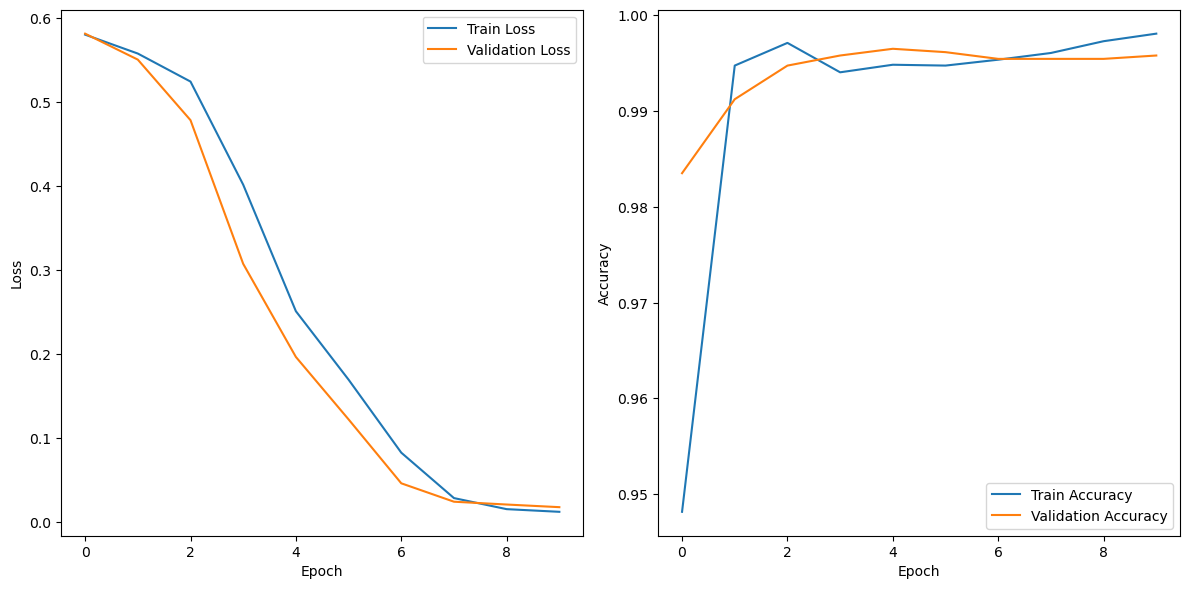

C:\Users\swaru\AppData\Local\Temp\ipykernel_192832\44560825.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_text_features = torch.load('clip_test_text_features.pt'

Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test labels features shape: torch.Size([1930])
Precision: 0.7644
Recall: 0.7568
F1 Score: 0.7606
Accuracy: 0.7005
Class 0: Precision=0.60, Recall=0.61, F1 Score=0.60
Class 1: Precision=0.76, Recall=0.76, F1 Score=0.76


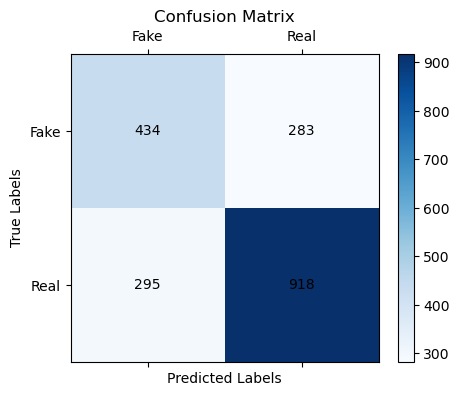

{'precision': 0.7643630308076603,
 'recall': 0.7568013190436933,
 'f1_score': 0.7605633802816901,
 'accuracy': 0.7005181347150259,
 'confusion_matrix': array([[434, 283],
        [295, 918]], dtype=int64)}

In [5]:
# Device configuration
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda'
# Load and preprocess dataset
text_features = torch.load('clip_train_text_features.pt').to(device, dtype=torch.float32)
print(f"Train text features shape: {text_features.shape}")
image_features = torch.load('clip_train_image_features.pt').to(device, dtype=torch.float32)
print(f"Train image features shape: {image_features.shape}")
train_imagesX = np.load('traslate_train_images_64.npy')
labels = torch.load('clip_train_label.pt').to(device, dtype=torch.float32)
train_imagesX = train_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
train_imagesX_tensor = torch.from_numpy(train_imagesX).permute(0, 3, 1, 2).to(device)  # Convert (N, H, W, C) to (N, C, H, W) and move to device

model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=4).to(device)
trained_model = train_model_with_plot(model,text_features,image_features,train_imagesX_tensor,labels,num_epochs=10,learning_rate=1e-4,margin=0.5,batch_size=256,device=device)

test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
test_imagesX = np.load('traslate_test_images_64.npy')
test_imagesX = test_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
test_imagesX_tensor = torch.from_numpy(test_imagesX).permute(0, 3, 1, 2).to(device) 
test_model(trained_model, test_text_features, test_image_features, test_imagesX_tensor, test_labels, batch_size=32)

# The save model

In [6]:
filename = "model_new_clip_architecture.pth"
    # Save the model
torch.save(trained_model.state_dict(), filename)
print(f"Model saved as {filename}")

Model saved as model_new_clip_architecture.pth


In [4]:
# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=4).to(device)
model.load_state_dict(torch.load("model_new_clip_architecture.pth"))

test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
test_imagesX = np.load('traslate_test_images_64.npy')
test_imagesX = test_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
test_imagesX_tensor = torch.from_numpy(test_imagesX).permute(0, 3, 1, 2).to(device) 
test_model(trained_model, test_text_features, test_image_features, test_imagesX_tensor, test_labels, batch_size=32)

C:\Users\swaru\AppData\Local\Temp\ipykernel_28324\1175385320.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_new_clip_architectur

FileNotFoundError: [Errno 2] No such file or directory: 'model_new_clip_architecture.pth'

C:\Users\swaru\AppData\Local\Temp\ipykernel_192832\1364484271.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_features = torch.load('clip_train_text_features.pt').t

Train text features shape: torch.Size([14254, 512])
Train image features shape: torch.Size([14254, 512])
train_text_features device: cuda:0
train_image_features device: cuda:0
train_image device: cuda:0
train_labels device: cuda:0
val_text_features device: cuda:0
val_image_features device: cuda:0
val_image device: cuda:0
val_labels device: cuda:0
Epoch 1/20, Train Loss: 0.6635, Train Acc: 0.6554, Val Loss: 0.6621, Val Acc: 0.6589
Epoch 2/20, Train Loss: 0.6593, Train Acc: 0.6554, Val Loss: 0.6559, Val Acc: 0.6589
Epoch 3/20, Train Loss: 0.6467, Train Acc: 0.6554, Val Loss: 0.6334, Val Acc: 0.6589
Epoch 4/20, Train Loss: 0.6112, Train Acc: 0.6554, Val Loss: 0.5821, Val Acc: 0.6589
Epoch 5/20, Train Loss: 0.5402, Train Acc: 0.7295, Val Loss: 0.4900, Val Acc: 0.9947
Epoch 6/20, Train Loss: 0.4284, Train Acc: 0.9953, Val Loss: 0.3630, Val Acc: 0.9926
Epoch 7/20, Train Loss: 0.2965, Train Acc: 0.9954, Val Loss: 0.2355, Val Acc: 0.9923
Epoch 8/20, Train Loss: 0.1827, Train Acc: 0.9953, Val L

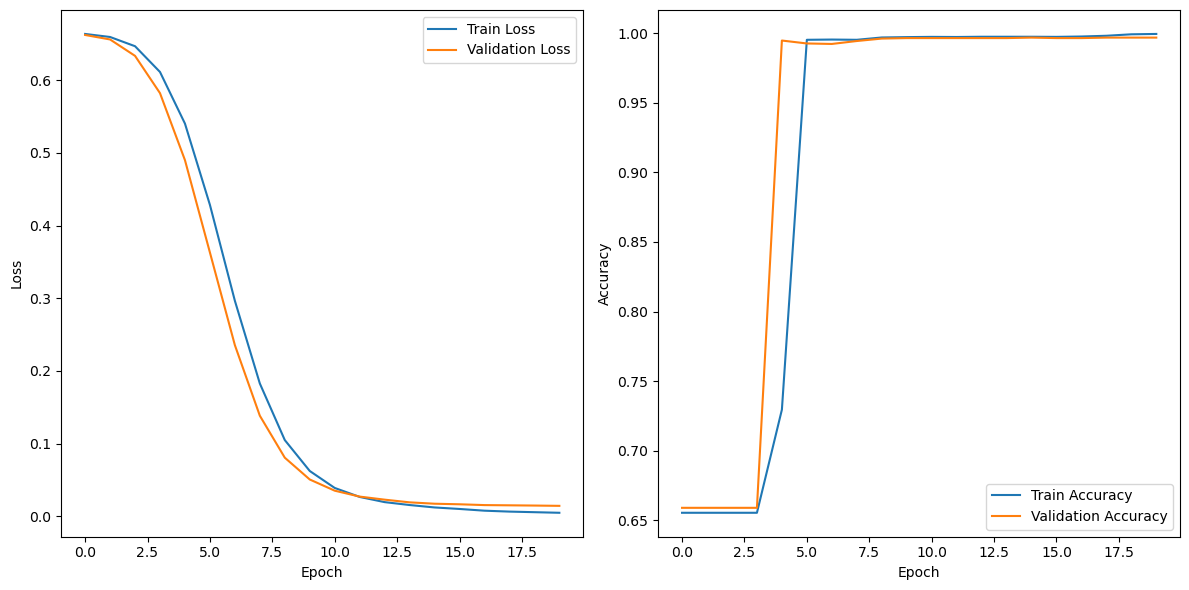

C:\Users\swaru\AppData\Local\Temp\ipykernel_192832\1364484271.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_text_features = torch.load('clip_test_text_features.p

Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test labels features shape: torch.Size([1930])
Precision: 0.9300
Recall: 0.7560
F1 Score: 0.8340
Accuracy: 0.8109
Class 0: Precision=0.69, Recall=0.90, F1 Score=0.78
Class 1: Precision=0.93, Recall=0.76, F1 Score=0.83


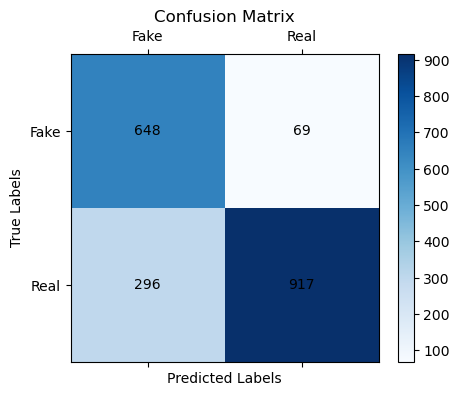

{'precision': 0.9300202839756593,
 'recall': 0.7559769167353668,
 'f1_score': 0.8340154615734425,
 'accuracy': 0.810880829015544,
 'confusion_matrix': array([[648,  69],
        [296, 917]], dtype=int64)}

In [9]:
# Device configuration
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda'
# Load and preprocess dataset
text_features = torch.load('clip_train_text_features.pt').to(device, dtype=torch.float32)
print(f"Train text features shape: {text_features.shape}")
image_features = torch.load('clip_train_image_features.pt').to(device, dtype=torch.float32)
print(f"Train image features shape: {image_features.shape}")
train_imagesX = np.load('traslate_train_images_64.npy')
labels = torch.load('clip_train_label.pt').to(device, dtype=torch.float32)
train_imagesX = train_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
train_imagesX_tensor = torch.from_numpy(train_imagesX).permute(0, 3, 1, 2).to(device)  # Convert (N, H, W, C) to (N, C, H, W) and move to device

model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=2).to(device)
trained_model = train_model_with_plot(model,text_features,image_features,train_imagesX_tensor,labels,num_epochs=20,learning_rate=1e-4,margin=0.5,batch_size=256,device=device)

test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
test_imagesX = np.load('traslate_test_images_64.npy')
test_imagesX = test_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
test_imagesX_tensor = torch.from_numpy(test_imagesX).permute(0, 3, 1, 2).to(device) 
test_model(trained_model, test_text_features, test_image_features, test_imagesX_tensor, test_labels, batch_size=32)

C:\Users\swaru\AppData\Local\Temp\ipykernel_192832\1598666072.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_new_clip_architectu

Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test labels features shape: torch.Size([1930])
Precision: 0.9138
Recall: 0.8566
F1 Score: 0.8843
Accuracy: 0.8591
Class 0: Precision=0.78, Recall=0.86, F1 Score=0.82
Class 1: Precision=0.91, Recall=0.86, F1 Score=0.88


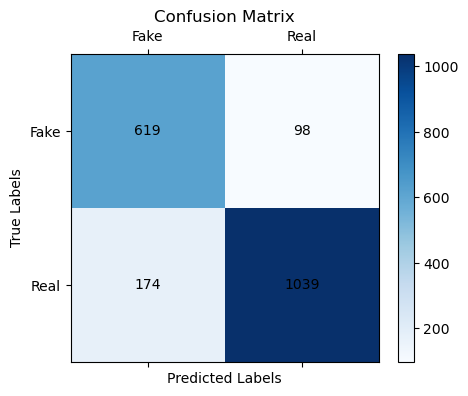

{'precision': 0.9138082673702727,
 'recall': 0.8565539983511954,
 'f1_score': 0.8842553191489362,
 'accuracy': 0.8590673575129534,
 'confusion_matrix': array([[ 619,   98],
        [ 174, 1039]], dtype=int64)}

In [19]:
# filename = "model_new_clip_architecture_updated.pth"
#     # Save the model
# torch.save(trained_model.state_dict(), filename)
# print(f"Model saved as {filename}")
model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=2).to(device)
model.load_state_dict(torch.load("model_new_clip_architecture_updated.pth"))

test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
test_imagesX = np.load('traslate_test_images_64.npy')
test_imagesX = test_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
test_imagesX_tensor = torch.from_numpy(test_imagesX).permute(0, 3, 1, 2).to(device) 
test_model(trained_model, test_text_features, test_image_features, test_imagesX_tensor, test_labels, batch_size=32)

# The test single image

In [43]:
import torch
import numpy as np

# Load the pre-trained model
filename = "model_new_clip_architecture_updated.pth"
model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=2).to(device)
model.load_state_dict(torch.load(filename))
model.eval()  # Set the model to evaluation mode

# Load single data point
test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
test_label = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test label

test_imagesX = np.load('traslate_test_images_64.npy')
test_imagesX = test_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
test_imagesX_tensor = torch.from_numpy(test_imagesX).permute(0, 3, 1, 2).to(device)  # (batch_size, C, H, W)

idx = 1825  # Select the index of the data point you want to test
# Check dimensions
print(f"Test text features shape: {test_text_features.shape}")
print(f"Test image features shape: {test_image_features.shape}")
print(f"Test image tensor shape: {test_imagesX_tensor[idx].shape}")

# Forward pass
with torch.no_grad():
    output = model(test_text_features[idx].unsqueeze(0), test_image_features[idx].unsqueeze(0), test_imagesX_tensor[idx].unsqueeze(0))
    print(f"Output: {output.item()}")
    probabilities = output.squeeze().cpu().numpy()  # Convert to numpy
    predictions = (probabilities >= 0.5).astype(int)  # Binary classification
    # Compare with label
    print(f"Predicted label: {'Real' if predictions >=0.5 else 'Fake'}")

# Compare with label
print(f"Actual label: {test_label[idx].item()}")


C:\Users\swaru\AppData\Local\Temp\ipykernel_192832\469480609.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))
C:\Users\swaru\A

Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test image tensor shape: torch.Size([3, 64, 64])
Output: 4.584573268890381
Predicted label: Real
Actual label: 1.0


C:\Users\swaru\AppData\Local\Temp\ipykernel_192832\1364484271.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_features = torch.load('clip_train_text_features.pt').t

Train text features shape: torch.Size([14254, 512])
Train image features shape: torch.Size([14254, 512])
train_text_features device: cuda:0
train_image_features device: cuda:0
train_image device: cuda:0
train_labels device: cuda:0
val_text_features device: cuda:0
val_image_features device: cuda:0
val_image device: cuda:0
val_labels device: cuda:0
Epoch 1/20, Train Loss: 0.6173, Train Acc: 0.6568, Val Loss: 0.6125, Val Acc: 0.6533
Epoch 2/20, Train Loss: 0.5913, Train Acc: 0.6568, Val Loss: 0.5606, Val Acc: 0.6533
Epoch 3/20, Train Loss: 0.4982, Train Acc: 0.7984, Val Loss: 0.4289, Val Acc: 0.9930
Epoch 4/20, Train Loss: 0.3410, Train Acc: 0.9952, Val Loss: 0.2583, Val Acc: 0.9958
Epoch 5/20, Train Loss: 0.1877, Train Acc: 0.9947, Val Loss: 0.1325, Val Acc: 0.9961
Epoch 6/20, Train Loss: 0.0951, Train Acc: 0.9954, Val Loss: 0.0729, Val Acc: 0.9961
Epoch 7/20, Train Loss: 0.0528, Train Acc: 0.9958, Val Loss: 0.0463, Val Acc: 0.9958
Epoch 8/20, Train Loss: 0.0321, Train Acc: 0.9970, Val L

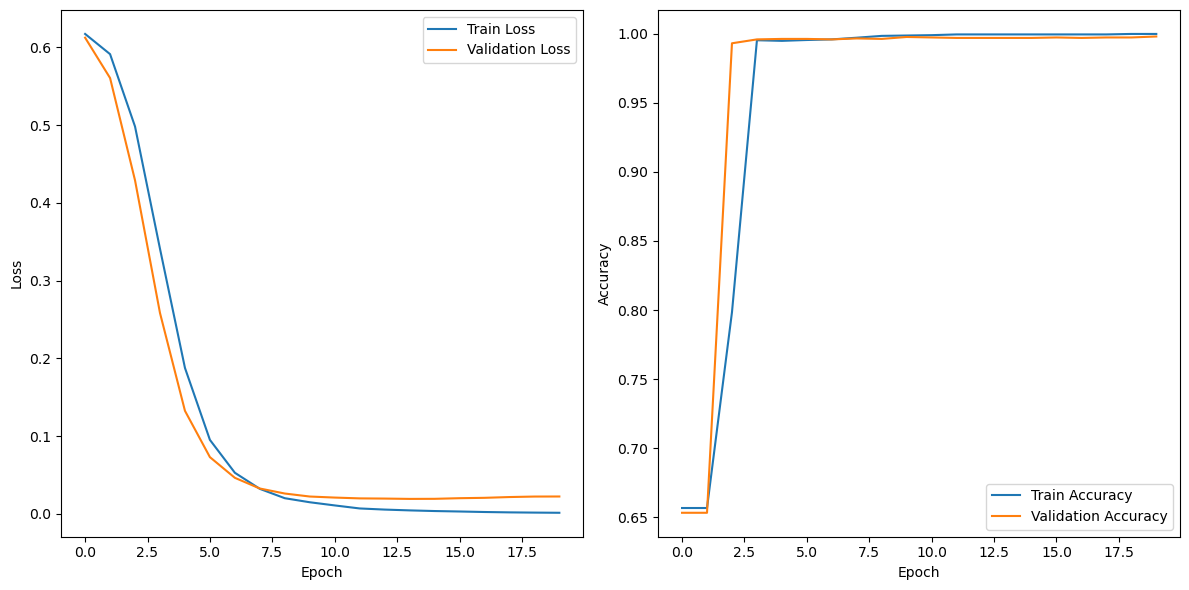

C:\Users\swaru\AppData\Local\Temp\ipykernel_192832\1364484271.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_text_features = torch.load('clip_test_text_features.p

Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test labels features shape: torch.Size([1930])
Precision: 0.9412
Recall: 0.8450
F1 Score: 0.8905
Accuracy: 0.8694
Class 0: Precision=0.78, Recall=0.91, F1 Score=0.84
Class 1: Precision=0.94, Recall=0.85, F1 Score=0.89


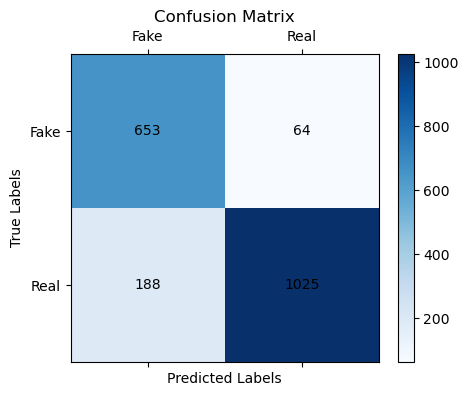

{'precision': 0.9412304866850322,
 'recall': 0.8450123660346249,
 'f1_score': 0.8905299739357081,
 'accuracy': 0.8694300518134715,
 'confusion_matrix': array([[ 653,   64],
        [ 188, 1025]], dtype=int64)}

In [20]:
# Device configuration
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda'
# Load and preprocess dataset
text_features = torch.load('clip_train_text_features.pt').to(device, dtype=torch.float32)
print(f"Train text features shape: {text_features.shape}")
image_features = torch.load('clip_train_image_features.pt').to(device, dtype=torch.float32)
print(f"Train image features shape: {image_features.shape}")
train_imagesX = np.load('traslate_train_images_64.npy')
labels = torch.load('clip_train_label.pt').to(device, dtype=torch.float32)
train_imagesX = train_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
train_imagesX_tensor = torch.from_numpy(train_imagesX).permute(0, 3, 1, 2).to(device)  # Convert (N, H, W, C) to (N, C, H, W) and move to device

model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=2).to(device)
trained_model = train_model_with_plot(model,text_features,image_features,train_imagesX_tensor,labels,num_epochs=20,learning_rate=1e-4,margin=0.5,batch_size=256,device=device)

test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
test_imagesX = np.load('traslate_test_images_64.npy')
test_imagesX = test_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
test_imagesX_tensor = torch.from_numpy(test_imagesX).permute(0, 3, 1, 2).to(device) 
test_model(trained_model, test_text_features, test_image_features, test_imagesX_tensor, test_labels, batch_size=32)

#AP Curve

C:\Users\swaru\AppData\Local\Temp\ipykernel_28324\1804924900.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load("model_new_clip_arc

Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test labels features shape: torch.Size([1930])
Precision: 0.9138
Recall: 0.8566
F1 Score: 0.8843
Accuracy: 0.8591
Class 0: Precision=0.78, Recall=0.86, F1 Score=0.82
Class 1: Precision=0.91, Recall=0.86, F1 Score=0.88


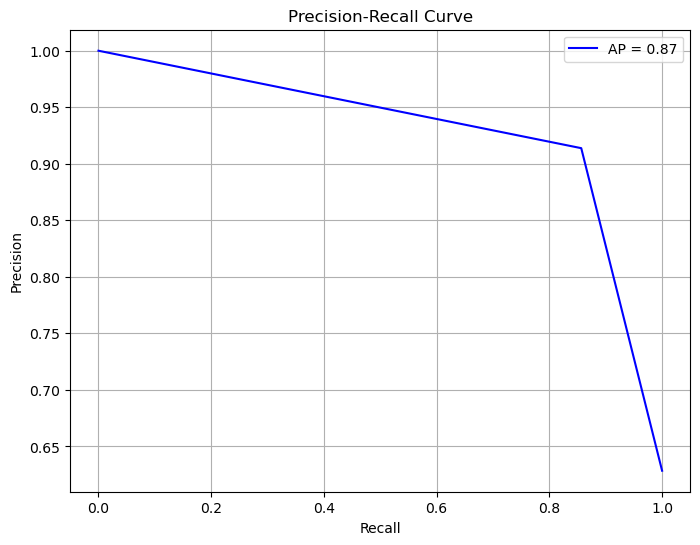

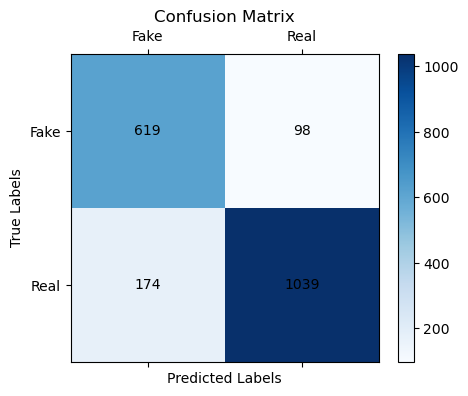

{'precision': array([0.62849741, 0.91380827, 1.        ]),
 'recall': array([1.      , 0.856554, 0.      ]),
 'f1_score': 0.8842553191489362,
 'accuracy': 0.8590673575129534,
 'confusion_matrix': array([[ 619,   98],
        [ 174, 1039]], dtype=int64)}

In [14]:
filename = "model_new_clip_architecture_updated_updated.pth"
    # Save the mode
trained_model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=2).to(device)
trained_model.load_state_dict(torch.load("model_new_clip_architecture_updated_updated.pth"))

test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
test_imagesX = np.load('traslate_test_images_64.npy')
test_imagesX = test_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
test_imagesX_tensor = torch.from_numpy(test_imagesX).permute(0, 3, 1, 2).to(device) 
test_model(trained_model, test_text_features, test_image_features, test_imagesX_tensor, test_labels, batch_size=32)

# Model without image processing layer

In [15]:

class MMoE(nn.Module):
    def __init__(self, input_dim, expert_dim, num_experts, num_tasks, output_dim, num_fc_layers=2):
        """
        Initialize the MMoE model.

        Args:
            input_dim (int): Input dimension for the features.
            expert_dim (int): Dimensionality of the output from each expert.
            num_experts (int): Number of experts in the MMoE model.
            num_tasks (int): Number of tasks to be solved (e.g., classification tasks).
            output_dim (int): Output dimension for each task.
            num_fc_layers (int): Number of fully connected layers in the experts and gates.
        """
        super(MMoE, self).__init__()
        
        self.num_tasks = num_tasks
        self.num_experts = num_experts
        
        # Experts: A shared set of experts (fully connected layers)
        self.experts = nn.ModuleList([self._build_fc_layers(input_dim, expert_dim, num_fc_layers) for _ in range(num_experts)])
        
        # Gates: One gating network per task
        self.gates = nn.ModuleList([self._build_fc_layers(input_dim, num_experts, num_fc_layers) for _ in range(num_tasks)])
        
        # Output layers: One output layer per task
        self.output_layers = nn.ModuleList([nn.Linear(expert_dim, output_dim) for _ in range(num_tasks)])

    def _build_fc_layers(self, input_dim, output_dim, num_fc_layers):
        """Build a sequence of fully connected layers."""
        layers = []
        for i in range(num_fc_layers):
            in_dim = input_dim if i == 0 else output_dim
            layers.append(nn.Linear(in_dim, output_dim))
            if i < num_fc_layers - 1:  # No activation on the final layer
                layers.append(nn.ReLU())
        return nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass through the MMoE model.

        Args:
            x (Tensor): Input tensor (batch_size, input_dim).
        
        Returns:
            outputs (list of Tensors): A list of task-specific outputs.
        """
        # Get expert outputs
        expert_outputs = [expert(x) for expert in self.experts]
        #print("exper",expert_outputs.shape)
        
        # Stack expert outputs to shape (batch_size, num_experts, expert_dim)
        expert_outputs = torch.stack(expert_outputs, dim=1)
        
        # Get the output for each task
        outputs = []
        for i in range(self.num_tasks):
            gate_output = self.gates[i](x)  # (batch_size, num_experts)
            gate_output = F.softmax(gate_output, dim=1)  # Normalize to get the weights
            
            # Weighted sum of expert outputs for the task
            task_output = torch.sum(gate_output.unsqueeze(2) * expert_outputs, dim=1)  # (batch_size, expert_dim)
            
            # Apply task-specific output layer
            task_output = self.output_layers[i](task_output)
            outputs.append(task_output)
        
        return outputs




# Discriminator model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: (3, 64, 64)
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # (64, 32, 32)
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            
            nn.Flatten(),  # (512 * 4 * 4 = 8192)
            nn.Linear(512 * 4 * 4, 1),  # Fully connected layer to a single output
            nn.Sigmoid()  # Output: probability for binary classification
        )

    def forward(self, x):
        return self.model(x)

class TextImageSimilarityModel(nn.Module):
    def __init__(self, text_image_input_dim, input_dim, embed_dim, num_fc_layers, expert_dim, num_experts, num_tasks, output_dim, num_fc_layers_mmoe):
        super(TextImageSimilarityModel, self).__init__()
        
        # Text branch
        self.text_layers = self._build_fc_layers(input_dim, embed_dim, num_fc_layers)
        
        # Image branch
        self.image_layers = self._build_fc_layers(input_dim, embed_dim, num_fc_layers)
        
        self.mmoe = MMoE(text_image_input_dim, expert_dim, num_experts, num_tasks, output_dim, num_fc_layers_mmoe)
        
        self.discriminator = Discriminator()
        
        # Final fully connected layer for output
        self.fc_layer = nn.Linear( output_dim+1, 1)  # Adjust based on the concatenated dimensions
        
    def _build_fc_layers(self, input_dim, embed_dim, num_fc_layers):
        layers = []
        for i in range(num_fc_layers):
            in_dim = input_dim if i == 0 else embed_dim
            out_dim = embed_dim
            layers.append(nn.Linear(in_dim, out_dim))
            if i < num_fc_layers - 1:
                layers.append(nn.ReLU())
        return nn.Sequential(*layers)
    
    def forward(self, text_features, image_features, image):
        # Process text features
        text_embedding = self.text_layers(text_features)
        text_embedding = F.normalize(text_embedding, dim=-1)
        
        # Process image features
        image_embedding = self.image_layers(image_features)
        image_embedding = F.normalize(image_embedding, dim=-1)
        
        # Concatenate the text and image embeddings
        combined_features = torch.cat([text_embedding, image_embedding], dim=-1)
        
        # Pass the combined features to MMoE
        task_outputs = self.mmoe(combined_features)
        
        # For discriminator
        out_dis = self.discriminator(image)
        
        # Concatenate task_outputs[0] and discriminator output
        
        combined_out =  torch.cat([task_outputs[0], out_dis], dim=-1)
        
        # Pass through the final FC layer
        out = self.fc_layer(combined_out)
        out = task_outputs[0]
        
        return out



#Example usage
model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=4)#.to('cuda')

# Dummy data
text_features = torch.randn(32, 512)  # Example text features batch (batch size, input_dim)
image_features = torch.randn(32, 512)  # Example image features batch (batch size, input_dim)
image = torch.randn(32, 3, 64, 64)  # Example image batch (batch size, channels, height, width)

# Forward pass
outputs = model(text_features, image_features, image)
print(outputs.shape)


torch.Size([32, 1])


C:\Users\swaru\AppData\Local\Temp\ipykernel_28436\44560825.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  text_features = torch.load('clip_train_text_features.pt').to(d

Train text features shape: torch.Size([14254, 512])
Train image features shape: torch.Size([14254, 512])
train_text_features device: cuda:0
train_image_features device: cuda:0
train_image device: cuda:0
train_labels device: cuda:0
val_text_features device: cuda:0
val_image_features device: cuda:0
val_image device: cuda:0
val_labels device: cuda:0
Epoch 1/10, Train Loss: 0.6872, Train Acc: 0.6243, Val Loss: 0.6765, Val Acc: 0.6761
Epoch 2/10, Train Loss: 0.6674, Train Acc: 0.6511, Val Loss: 0.6360, Val Acc: 0.6761
Epoch 3/10, Train Loss: 0.5631, Train Acc: 0.6511, Val Loss: 0.4323, Val Acc: 0.6761
Epoch 4/10, Train Loss: 0.3461, Train Acc: 0.7097, Val Loss: 0.2461, Val Acc: 0.9951
Epoch 5/10, Train Loss: 0.2219, Train Acc: 0.9932, Val Loss: 0.1561, Val Acc: 0.9951
Epoch 6/10, Train Loss: 0.1157, Train Acc: 0.9947, Val Loss: 0.0561, Val Acc: 0.9965
Epoch 7/10, Train Loss: 0.0364, Train Acc: 0.9963, Val Loss: 0.0210, Val Acc: 0.9972
Epoch 8/10, Train Loss: 0.0162, Train Acc: 0.9971, Val L

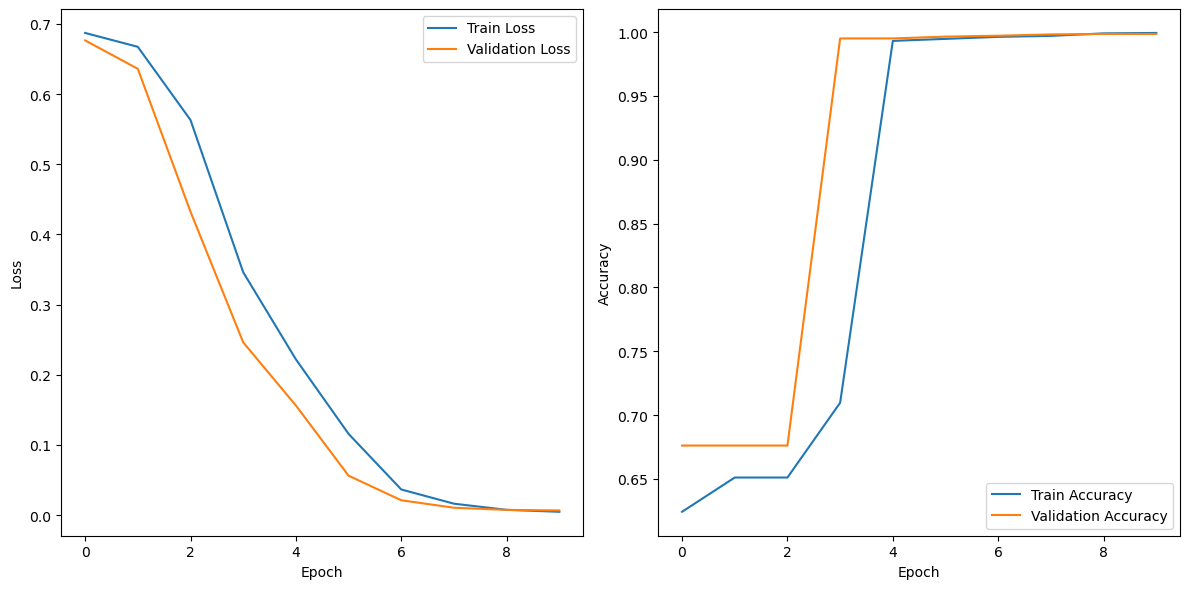

C:\Users\swaru\AppData\Local\Temp\ipykernel_28436\44560825.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_text_features = torch.load('clip_test_text_features.pt')

Test text features shape: torch.Size([1930, 512])
Test image features shape: torch.Size([1930, 512])
Test labels features shape: torch.Size([1930])
Precision: 0.5397
Recall: 0.0561
F1 Score: 0.1016
Accuracy: 0.3767
Class 0: Precision=0.37, Recall=0.92, F1 Score=0.52
Class 1: Precision=0.54, Recall=0.06, F1 Score=0.10


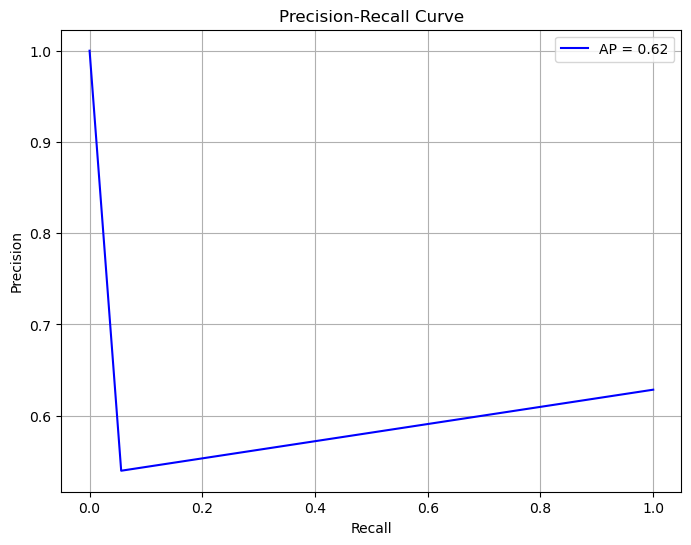

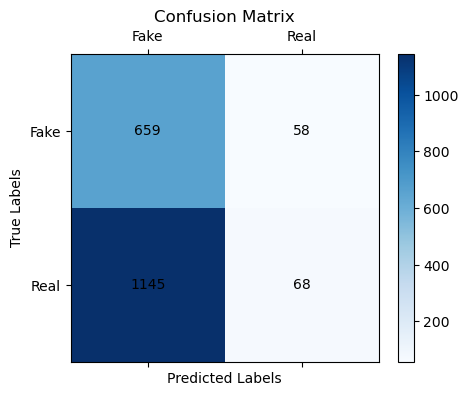

{'precision': array([0.62849741, 0.53968254, 1.        ]),
 'recall': array([1.        , 0.05605936, 0.        ]),
 'f1_score': 0.10156833457804332,
 'accuracy': 0.3766839378238342,
 'confusion_matrix': array([[ 659,   58],
        [1145,   68]], dtype=int64)}

In [23]:
# Device configuration
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda'
# Load and preprocess dataset
text_features = torch.load('clip_train_text_features.pt').to(device, dtype=torch.float32)
print(f"Train text features shape: {text_features.shape}")
image_features = torch.load('clip_train_image_features.pt').to(device, dtype=torch.float32)
print(f"Train image features shape: {image_features.shape}")
train_imagesX = np.load('traslate_train_images_64.npy')
labels = torch.load('clip_train_label.pt').to(device, dtype=torch.float32)
train_imagesX = train_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
train_imagesX_tensor = torch.from_numpy(train_imagesX).permute(0, 3, 1, 2).to(device)  # Convert (N, H, W, C) to (N, C, H, W) and move to device

model = TextImageSimilarityModel(text_image_input_dim=512, input_dim=512, embed_dim=256, num_fc_layers=4, 
                                 expert_dim=64, num_experts=8, num_tasks=2, output_dim=1, num_fc_layers_mmoe=4).to(device)
trained_model = train_model_with_plot(model,text_features,image_features,train_imagesX_tensor,labels,num_epochs=10,learning_rate=1e-4,margin=0.5,batch_size=256,device=device)

test_text_features = torch.load('clip_test_text_features.pt').to(device, dtype=torch.float32)
print(f"Test text features shape: {test_text_features.shape}")
test_image_features = torch.load('clip_test_image_features.pt').to(device, dtype=torch.float32)
print(f"Test image features shape: {test_image_features.shape}")
test_labels = torch.load('clip_test_label.pt').to(device, dtype=torch.float32)  # Test labels
print(f"Test labels features shape: {test_labels.shape}")
test_imagesX = np.load('traslate_test_images_64.npy')
test_imagesX = test_imagesX.astype(np.float32) / 255.0  # Normalize images (scale pixel values to [0, 1])
# Convert train_imagesX to PyTorch tensor and move to device
test_imagesX_tensor = torch.from_numpy(test_imagesX).permute(0, 3, 1, 2).to(device) 
test_model(trained_model, test_text_features, test_image_features, test_imagesX_tensor, test_labels, batch_size=32)